# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Image normalization between [-1;1]
])

# choose the training and test datasets
train_dataset = datasets.MNIST(root='data', train=True,
                               download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# Split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(0.8 * len(train_dataset))      # 80% for training
valid_size = len(train_dataset) - train_size    # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

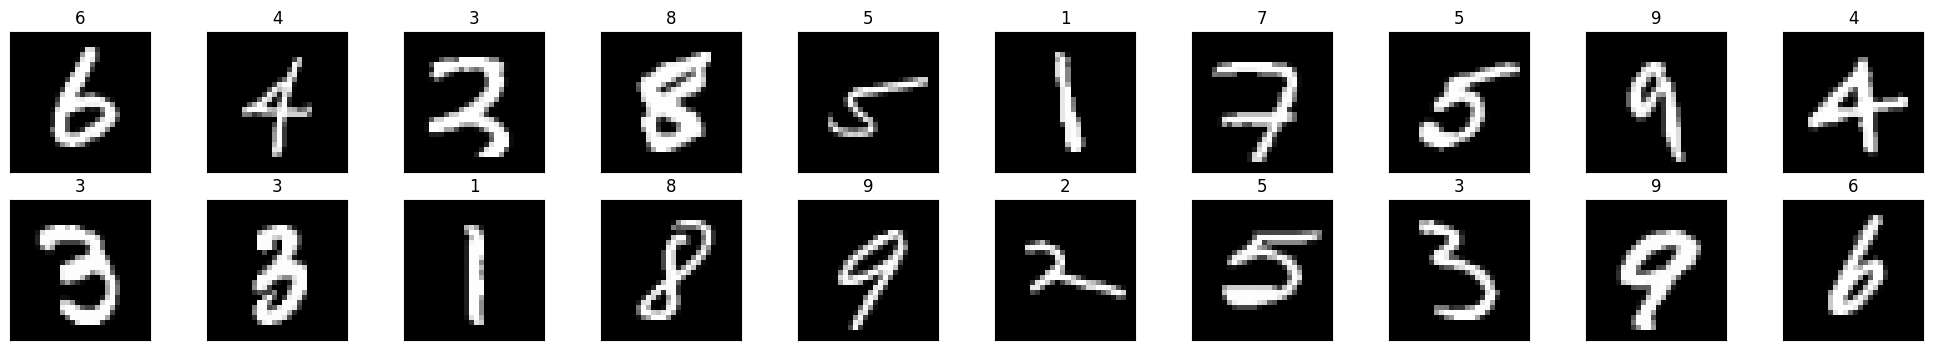

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

(28, 28)


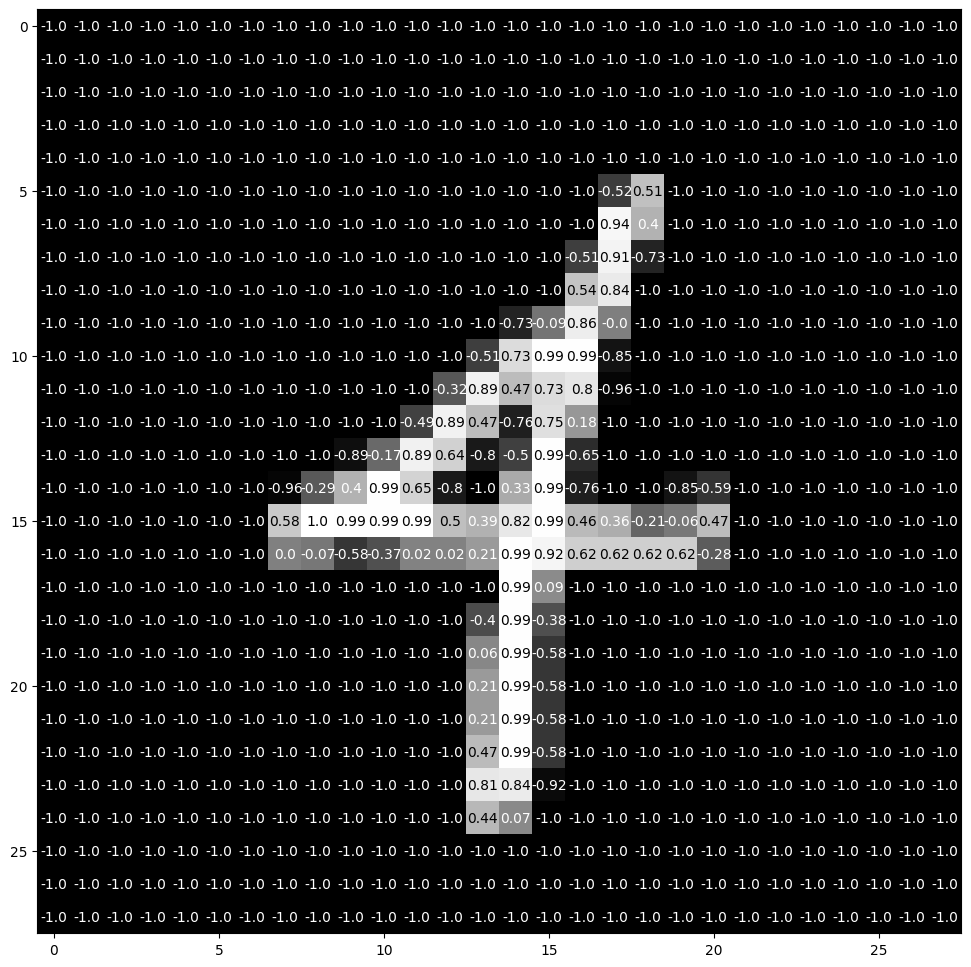

In [4]:
img = np.squeeze(images[1])
print(img.shape)

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [5]:
# Parameters
learning_rate = 0.01
n_epochs = 15         # number of epochs to train the model (suggest training between 20-50 epochs)
input_size = 28 * 28  # size of the MNIST images (28x28 pixels)
num_classes = 10      # 10 classes (digit from 0 to 9)

In [6]:
## Define the NN architecture
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_units, num_classes):
        super(SimpleMLP, self).__init__()                
        self.fc1 = nn.Linear(input_size, hidden_units[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_units[1], num_classes)        

    def forward(self, x):
        x = x.view(-1, input_size) # flatten image input
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)        
        return x

# initialize the NN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP(input_size=input_size, hidden_units=[128, 64], num_classes=num_classes).to(device)
print(model)
print(f"MLP: total number of parameters : {sum(p.numel() for p in model.parameters())}")

SimpleMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
MLP: total number of parameters : 109386


In [7]:
# Define the basic CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Fully connected layers after flattening
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # 7x7 is the image size after pooling
        self.fc2 = nn.Linear(64, 10)  # 10 output classes for classification (e.g., MNIST)
        
        # Pooling layer (max-pooling 2x2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the ReLU activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU and max pooling
        x = self.pool(self.relu(self.conv1(x)))
        # Apply the second convolutional layer followed by ReLU and max pooling
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten the output for fully connected layers
        x = x.view(-1, 32 * 7 * 7)
        # Pass through the first fully connected layer with ReLU
        x = self.relu(self.fc1(x))
        # Final output through the second fully connected layer
        x = self.fc2(x)
        return x
    
# initialize the NN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print(model)
print(f"CNN: Total number of parameters : {sum(p.numel() for p in model.parameters())}")

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)
CNN: Total number of parameters : 105866


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [8]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [9]:
# Lists to store loss and accuracy for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

best_valid_loss = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    correct_train = 0
    total_train = 0    
    model.train()  # ensure the model is in training mode
    
    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        data, target = batch_data[0].to(device), batch_data[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        # Calculate accuracy for training set
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()        
        
    # Calculate average training loss and accuracy over the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            data, target = batch_data[0].to(device), batch_data[1].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss
            valid_loss += loss.item() * data.size(0)

            # Calculate accuracy
            _, predicted_valid = torch.max(output, 1)
            total_valid += target.size(0)
            correct_valid += (predicted_valid == target).sum().item()

    # Compute average validation loss and accuracy
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {valid_accuracy:.2f}%')

    #print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} 
    #      \tValidation Loss: {valid_loss:.6f} 
    #      \tValidation Accuracy: {valid_accuracy:.2f}%')

    # Save the model if it has the best validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.6f}")



Epoch: 1 	Training Loss: 0.583594 	Validation Loss: 0.138599 	Validation Accuracy: 95.61%
Epoch: 2 	Training Loss: 0.113877 	Validation Loss: 0.087471 	Validation Accuracy: 97.33%
Epoch: 3 	Training Loss: 0.082226 	Validation Loss: 0.085019 	Validation Accuracy: 97.43%
Epoch: 4 	Training Loss: 0.065927 	Validation Loss: 0.066491 	Validation Accuracy: 98.00%
Epoch: 5 	Training Loss: 0.056684 	Validation Loss: 0.060415 	Validation Accuracy: 98.01%
Epoch: 6 	Training Loss: 0.049177 	Validation Loss: 0.047896 	Validation Accuracy: 98.47%
Epoch: 7 	Training Loss: 0.043149 	Validation Loss: 0.045656 	Validation Accuracy: 98.66%
Epoch: 8 	Training Loss: 0.037546 	Validation Loss: 0.054603 	Validation Accuracy: 98.23%
Epoch: 9 	Training Loss: 0.034593 	Validation Loss: 0.043275 	Validation Accuracy: 98.67%
Epoch: 10 	Training Loss: 0.030852 	Validation Loss: 0.040531 	Validation Accuracy: 98.71%
Epoch: 11 	Training Loss: 0.027829 	Validation Loss: 0.039231 	Validation Accuracy: 98.77%
Epoch: 1

---
## Display train / valid curves

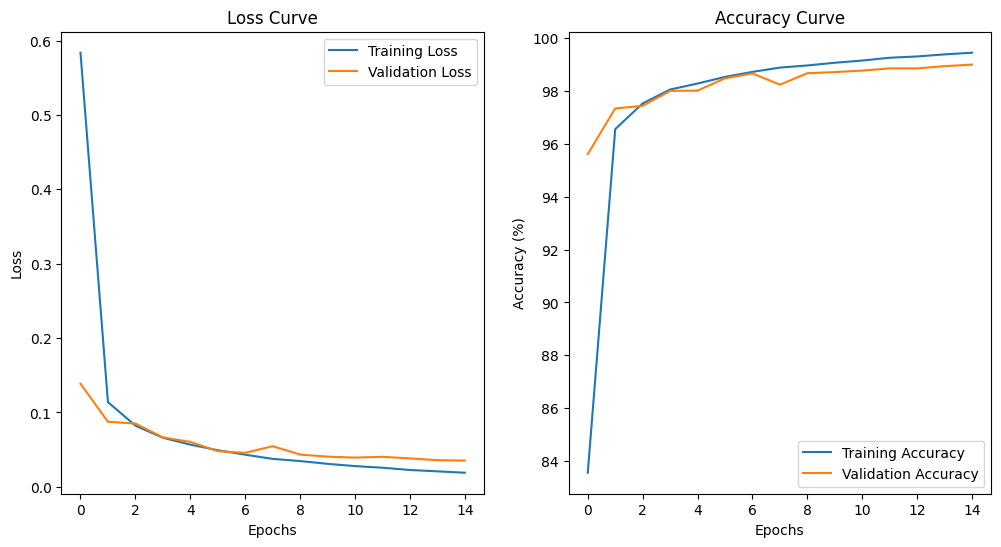

In [10]:
# Plot loss curves
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()


---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [11]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for batch_data in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    data, target = batch_data[0].to(device), batch_data[1].to(device)
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.035687

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1132/1135)
Test Accuracy of     2: 98% (1016/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 99% (978/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 98% (1014/1028)
Test Accuracy of     8: 97% (953/974)
Test Accuracy of     9: 97% (988/1009)

Test Accuracy (Overall): 98% (9885/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

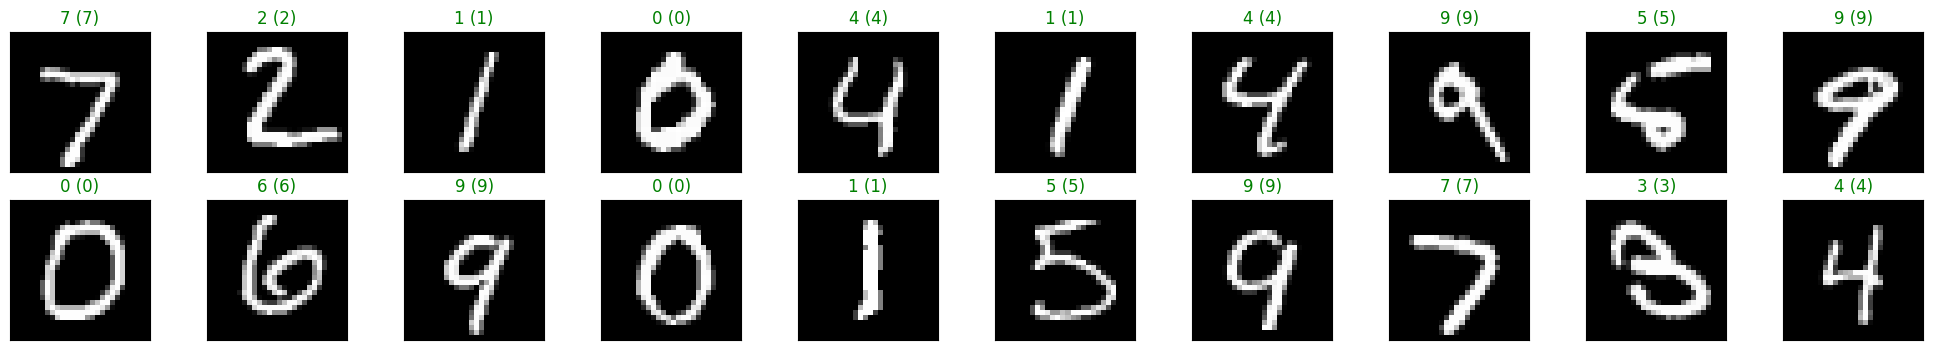

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
batch_data = next(dataiter)

# get sample outputs
images, labels = batch_data[0].to(device), batch_data[1].to(device)
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))